In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

In [4]:
"""
  Convolutional structure for the encoder net
"""

encoder = tf.keras.Sequential([
    layers.Conv2D(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=512, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Flatten()
])

"""
  DeConv structure for the decoder net
"""

decoder = tf.keras.Sequential([
    layers.Dense(2048),
    layers.Reshape(target_shape=(4, 4, 128), input_shape=(None, 1024)),
    layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=3  , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
])

In [16]:
batch_size = 250

x = tf.placeholder(tf.float32, shape=[batch_size, 32, 32, 3])

encoded = encoder(x)
mean_layer = layers.Dense(1024, tf.nn.softplus)
sigma_layer = layers.Dense(1024, tf.nn.relu)

mean = mean_layer(encoded)
sigma = sigma_layer(encoded)

z = mean + tf.multiply(tf.sqrt(tf.exp(sigma)),
                       tf.random_normal(shape=(batch_size, 1024)))

x_reco = decoder(z)

In [17]:
reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(
    layers.Flatten()(x_reco), scale_identity_multiplier=0.05).log_prob(layers.Flatten()(x)))

kl_divergence = tf.reduce_sum(tf.keras.metrics.kullback_leibler_divergence(x, x_reco), axis=[1, 2])

cost = tf.reduce_mean(reconstruction_term + kl_divergence)

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [19]:
from tensorflow.keras.datasets.cifar10 import load_data
(X_train, y_train), (X_test, y_test) = load_data()

In [20]:
runs = 20
n_minibatches = int(X_train.shape[0] / batch_size)

print("Number of minibatches: ", n_minibatches)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(runs):
    
    for i in range(n_minibatches):
        
        x_batch = X_train[i*batch_size:(i+1)*batch_size]/255.
        cost_, _ = sess.run((cost, optimizer), feed_dict={x: x_batch})
        print(cost_, i, epoch)

        

Number of minibatches:  200


/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


37354024.0 0 0
37299344.0 1 0
36078108.0 2 0
34327890.0 3 0
33171556.0 4 0
29735058.0 5 0
29307294.0 6 0
25124302.0 7 0
24511068.0 8 0
23324750.0 9 0
23738188.0 10 0
21449982.0 11 0
21926788.0 12 0
20339110.0 13 0
19487030.0 14 0
17959342.0 15 0
16448498.0 16 0
17339052.0 17 0
17395616.0 18 0
15501149.0 19 0
15447523.0 20 0
15728257.0 21 0
14237463.0 22 0
15329780.0 23 0
13890185.0 24 0
13703396.0 25 0
13275558.0 26 0
12183753.0 27 0
12383072.0 28 0
11810505.0 29 0
12014453.0 30 0
11134056.0 31 0
11059067.0 32 0
10837501.0 33 0
10477919.0 34 0
10665236.0 35 0
9656997.0 36 0
9678378.0 37 0
9082843.0 38 0
9149197.0 39 0
8658931.0 40 0
8999042.0 41 0
8622565.0 42 0
8343551.0 43 0
8265556.0 44 0
7953018.0 45 0
7817730.0 46 0
7644288.0 47 0
7194678.5 48 0
7477160.5 49 0
7237880.0 50 0
7502943.0 51 0
7482138.0 52 0
6868329.5 53 0
6799880.5 54 0
6702027.5 55 0
6864077.5 56 0
6651046.5 57 0
6464635.0 58 0
6363437.0 59 0
6536927.5 60 0
6346098.5 61 0
5909764.0 62 0
5956525.5 63 0
6365673.5 64 0

797383.0 134 2
983731.44 135 2
898032.8 136 2
852009.2 137 2
752727.0 138 2
863862.3 139 2
952279.94 140 2
795645.5 141 2
834313.5 142 2
742621.56 143 2
913127.44 144 2
917043.8 145 2
919619.75 146 2
874041.06 147 2
864842.7 148 2
915816.94 149 2
823370.75 150 2
857653.4 151 2
735500.94 152 2
762476.44 153 2
738479.8 154 2
749484.3 155 2
726176.44 156 2
800716.5 157 2
800715.8 158 2
734735.3 159 2
975183.6 160 2
763785.94 161 2
884166.6 162 2
988510.6 163 2
945961.0 164 2
805499.6 165 2
878945.1 166 2
696676.2 167 2
711741.6 168 2
722515.25 169 2
862442.06 170 2
810486.3 171 2
905245.44 172 2
851214.6 173 2
817990.8 174 2
787211.0 175 2
758190.3 176 2
915416.56 177 2
834505.25 178 2
714815.7 179 2
809973.2 180 2
800301.94 181 2
644867.8 182 2
790107.06 183 2
821371.75 184 2
863582.56 185 2
715987.56 186 2
681671.56 187 2
765213.94 188 2
645900.9 189 2
838141.06 190 2
650796.8 191 2
712240.9 192 2
702224.9 193 2
774152.2 194 2
761312.3 195 2
822871.5 196 2
678923.0 197 2
714978.44 198 2

317363.0 86 5
286011.9 87 5
370033.4 88 5
253451.1 89 5
259299.53 90 5
258220.55 91 5
299170.16 92 5
322631.25 93 5
288431.88 94 5
377906.06 95 5
306759.72 96 5
311552.1 97 5
294025.22 98 5
161488.22 99 5
391607.22 100 5
209384.7 101 5
311970.62 102 5
323752.84 103 5
239463.56 104 5
336176.2 105 5
288531.1 106 5
266838.34 107 5
164039.89 108 5
241876.7 109 5
313824.25 110 5
249741.55 111 5
306105.66 112 5
272313.72 113 5
349485.88 114 5
338871.6 115 5
359688.72 116 5
347389.53 117 5
303707.5 118 5
306786.97 119 5
321967.94 120 5
219440.03 121 5
305023.38 122 5
281289.8 123 5
241959.86 124 5
260695.45 125 5
307467.06 126 5
378671.9 127 5
200630.66 128 5
213384.12 129 5
176602.66 130 5
196581.27 131 5
247883.58 132 5
199455.58 133 5
207780.7 134 5
357670.2 135 5
323199.94 136 5
239928.5 137 5
173487.72 138 5
268422.8 139 5
328312.84 140 5
202905.5 141 5
256613.28 142 5
188324.5 143 5
319563.4 144 5
327968.3 145 5
320828.47 146 5
284542.22 147 5
292670.53 148 5
310750.78 149 5
245778.75 1

65704.74 26 8
29749.07 27 8
64044.926 28 8
63973.977 29 8
76202.0 30 8
20302.434 31 8
61544.203 32 8
11373.285 33 8
91792.875 34 8
131576.27 35 8
65448.453 36 8
-28061.328 37 8
-8887.643 38 8
25636.951 39 8
-123839.68 40 8
49965.57 41 8
31828.664 42 8
51968.8 43 8
-42310.0 44 8
-9827.934 45 8
121222.23 46 8
41094.38 47 8
-91298.69 48 8
47122.008 49 8
9507.045 50 8
17902.877 51 8
142473.62 52 8
20844.396 53 8
86788.7 54 8
1990.8867 55 8
58280.547 56 8
24270.107 57 8
15518.138 58 8
58399.07 59 8
-739.14996 60 8
55531.87 61 8
38159.848 62 8
-6567.254 63 8
-1815.9597 64 8
6535.745 65 8
12149.602 66 8
45342.332 67 8
14270.54 68 8
95507.22 69 8
-40969.938 70 8
52855.855 71 8
14814.032 72 8
-16763.213 73 8
32951.395 74 8
27815.576 75 8
-24743.732 76 8
27817.203 77 8
79664.16 78 8
-34087.402 79 8
-21138.033 80 8
-15158.943 81 8
-8859.501 82 8
57412.715 83 8
-26694.947 84 8
-66367.97 85 8
23780.201 86 8
1111.5879 87 8
72496.89 88 8
-27918.67 89 8
-7893.7783 90 8
-17843.389 91 8
7321.967 92 8
30

-181534.4 143 10
-64922.88 144 10
-81875.56 145 10
-68943.67 146 10
-115610.61 147 10
-119215.52 148 10
-108523.54 149 10
-144675.86 150 10
-106550.82 151 10
-187264.19 152 10
-183221.3 153 10
-205536.17 154 10
-188161.92 155 10
-185367.2 156 10
-173943.4 157 10
-148673.84 158 10
-186562.72 159 10
-55142.324 160 10
-219100.03 161 10
-178932.7 162 10
-134771.16 163 10
-130031.86 164 10
-185598.83 165 10
-116744.734 166 10
-221968.16 167 10
-200851.42 168 10
-230856.06 169 10
-135619.62 170 10
-125753.48 171 10
-94474.65 172 10
-147708.4 173 10
-166951.27 174 10
-180632.95 175 10
-201560.47 176 10
-113217.07 177 10
-144541.62 178 10
-200566.14 179 10
-123501.4 180 10
-138677.5 181 10
-188175.97 182 10
-139879.39 183 10
-133172.58 184 10
-108691.82 185 10
-220426.39 186 10
-208222.7 187 10
-155228.08 188 10
-236215.61 189 10
-114650.68 190 10
-244343.78 191 10
-193868.05 192 10
-197005.31 193 10
-157904.1 194 10
-151179.06 195 10
-103421.14 196 10
-208470.62 197 10
-178930.7 198 10
-21207

-351416.3 22 13
-325971.9 23 13
-296795.38 24 13
-301161.03 25 13
-261345.9 26 13
-283365.7 27 13
-282235.8 28 13
-285169.56 29 13
-286101.2 30 13
-333015.38 31 13
-323458.4 32 13
-344499.16 33 13
-306747.12 34 13
-263634.97 35 13
-306261.53 36 13
-363397.0 37 13
-344837.2 38 13
-315492.56 39 13
-409603.9 40 13
-297336.22 41 13
-300021.34 42 13
-300964.7 43 13
-370689.38 44 13
-343194.2 45 13
-261224.22 46 13
-300300.84 47 13
-414737.84 48 13
-298432.6 49 13
-328853.4 50 13
-316726.7 51 13
-245467.66 52 13
-341575.16 53 13
-274400.97 54 13
-334144.28 55 13
-292805.12 56 13
-323623.66 57 13
-330387.38 58 13
-298626.3 59 13
-345263.75 60 13
-302707.2 61 13
-311353.03 62 13
-335786.4 63 13
-342990.22 64 13
-330523.0 65 13
-327397.75 66 13
-300008.44 67 13
-320255.0 68 13
-256369.47 69 13
-370617.53 70 13
-306462.03 71 13
-319086.7 72 13
-344554.16 73 13
-313138.94 74 13
-311183.1 75 13
-364407.88 76 13
-307588.03 77 13
-265393.66 78 13
-360488.7 79 13
-371111.7 80 13
-352013.97 81 13
-361

-376711.9 105 15
-426385.28 106 15
-405236.75 107 15
-502225.06 108 15
-455258.56 109 15
-418879.28 110 15
-426927.28 111 15
-388291.66 112 15
-408079.7 113 15
-389905.97 114 15
-399498.75 115 15
-389973.3 116 15
-381721.1 117 15
-422040.03 118 15
-412897.84 119 15
-392895.0 120 15
-456942.72 121 15
-399896.56 122 15
-430071.22 123 15
-456651.44 124 15
-423052.28 125 15
-430099.6 126 15
-363608.03 127 15
-472475.06 128 15
-484627.7 129 15
-479827.2 130 15
-474095.16 131 15
-436758.78 132 15
-456830.53 133 15
-464003.16 134 15
-370313.5 135 15
-403039.2 136 15
-450780.1 137 15
-479193.84 138 15
-433076.72 139 15
-400817.47 140 15
-477429.38 141 15
-433341.03 142 15
-462873.47 143 15
-380935.7 144 15
-380837.75 145 15
-385124.7 146 15
-420085.38 147 15
-417915.66 148 15
-402889.97 149 15
-434965.8 150 15
-404768.22 151 15
-468216.62 152 15
-458747.75 153 15
-465156.47 154 15
-469340.2 155 15
-465814.2 156 15
-475324.47 157 15
-432017.7 158 15
-460133.84 159 15
-368259.97 160 15
-499639.5

-539459.94 182 17
-498610.62 183 17
-486212.44 184 17
-469042.75 185 17
-550032.94 186 17
-553619.6 187 17
-527809.44 188 17
-590955.25 189 17
-493615.47 190 17
-577491.1 191 17
-537652.44 192 17
-538510.8 193 17
-500405.56 194 17
-507740.1 195 17
-476376.84 196 17
-557368.7 197 17
-535766.2 198 17
-550098.1 199 17
-456668.8 0 18
-472382.22 1 18
-484577.72 2 18
-483319.28 3 18
-486380.1 4 18
-517308.22 5 18
-472059.78 6 18
-546441.44 7 18
-553567.06 8 18
-526384.75 9 18
-558346.94 10 18
-552608.8 11 18
-504590.66 12 18
-449812.84 13 18
-472769.12 14 18
-534887.1 15 18
-566928.6 16 18
-544748.5 17 18
-557156.2 18 18
-552132.94 19 18
-473714.38 20 18
-479040.97 21 18
-570791.5 22 18
-549011.9 23 18
-521708.5 24 18
-538062.06 25 18
-509313.84 26 18
-510704.0 27 18
-517390.72 28 18
-514494.47 29 18
-509784.25 30 18
-539099.25 31 18
-531014.3 32 18
-545294.2 33 18
-502938.16 34 18
-456325.25 35 18
-487134.25 36 18
-519321.6 37 18
-509145.9 38 18
-472971.53 39 18
-531567.4 40 18
-434227.38 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


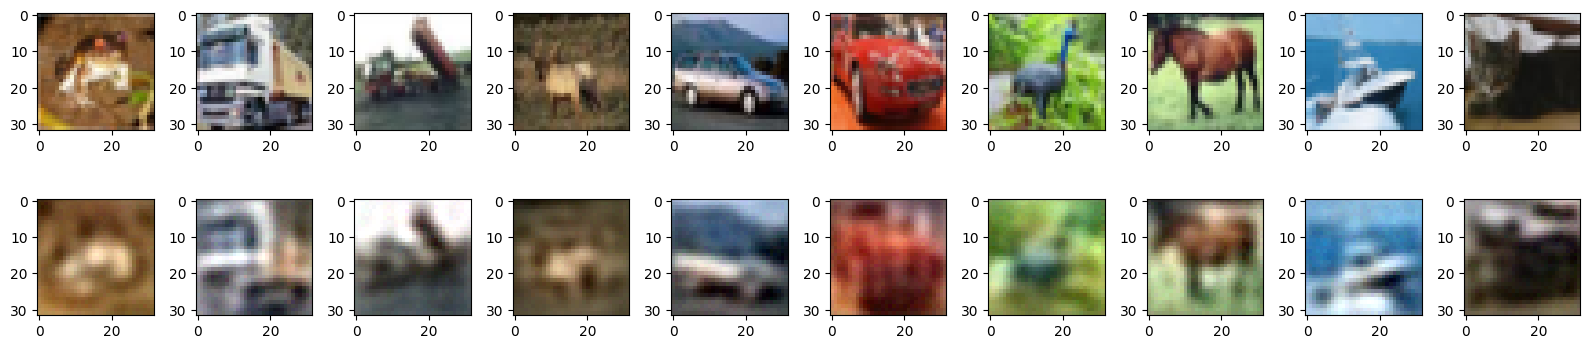

In [21]:
import matplotlib.pyplot as plt
import numpy as np

n_rec = 10

x_batch = X_train[0:batch_size]

plt.figure(figsize=(n_rec+6,4))

pred_img = sess.run(x_reco, feed_dict={x: x_batch})
pred_img = pred_img.reshape(batch_size, 32, 32, 3)
pred_img = pred_img.astype(np.int32)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i])

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()
plt.show()

In [22]:
some = encoder.predict(X_train)

In [23]:
mean = mean_layer(some)

In [24]:
logvar = sigma_layer(some)

In [27]:
mean.shape

TensorShape([Dimension(50000), Dimension(1024)])

In [28]:
z = mean + tf.multiply(tf.sqrt(tf.exp(logvar)),
                       tf.random_normal(shape=(50000, 1024)))

In [29]:
z.shape

TensorShape([Dimension(50000), Dimension(1024)])

In [31]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [40]:
# z_np = z.eval()
z_np

array([[3152.339 , 2590.617 , 2663.8164, ..., 2930.9536, 3342.8752,
        2848.1394],
       [2836.2961, 5167.644 , 3080.784 , ..., 3186.3357, 3000.905 ,
        3464.2441],
       [3215.4663, 3421.3406, 4660.5806, ..., 2874.6665, 2101.0679,
         453.696 ],
       ...,
       [1685.6392, 3684.3245, 3967.839 , ..., 2079.226 , 2041.6964,
         380.6775],
       [4831.996 , 4118.028 , 4396.424 , ..., 5334.0723, 3849.9116,
        4000.648 ],
       [2307.0984, 2582.1113, 3258.1511, ..., 2574.089 , 2906.3796,
        2222.7517]], dtype=float32)

In [37]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(z_np)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [6]:
from tensorflow.keras.layers import Input, InputLayer, concatenate

In [15]:
inp1 = Input(shape=(32,32,3))
inp2 = Input(shape=(None,None,10))

In [17]:
a=concatenate([inp1, inp2], axis=-1)

In [18]:
a.shape

TensorShape([None, 32, 32, 13])